In [1]:
import os
import json
import cv2
import librosa
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from warnings import filterwarnings

filterwarnings(action='ignore')

In [2]:
%pwd

'/content'

In [3]:
%cd /content/drive/MyDrive/github-project/Bird sound classification using deep learning

/content/drive/MyDrive/github-project/Bird sound classification using deep learning


In [4]:
%ls

'Bird sound classification.ipynb'   sound-of-114-species-of-birds-till-2022.zip
'Birds Voice.csv'                  'Voice of Birds'/


DATA COLLECTION

In [ ]:
# Download 'Sound Of 114 Species Of Birds Till 2022' dataset from Kaggle
# Dataset URL = https://www.kaggle.com/datasets/soumendraprasad/sound-of-114-species-of-birds-till-2022?select=Birds+Voice.csv

!kaggle datasets download -d soumendraprasad/sound-of-114-species-of-birds-till-2022

Dataset URL: https://www.kaggle.com/datasets/soumendraprasad/sound-of-114-species-of-birds-till-2022
License(s): CC0-1.0
sound-of-114-species-of-birds-till-2022.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip the dataset

!unzip sound-of-114-species-of-birds-till-2022.zip

Archive:  sound-of-114-species-of-birds-till-2022.zip
replace Birds Voice.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
%ls

'Bird sound classification.ipynb'   sound-of-114-species-of-birds-till-2022.zip
'Birds Voice.csv'                  'Voice of Birds'/


In [ ]:
/content/drive/MyDrive/github-project/Bird sound classification using deep learning/Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan10.mp3

SAMPLE AUDIO CHECKING

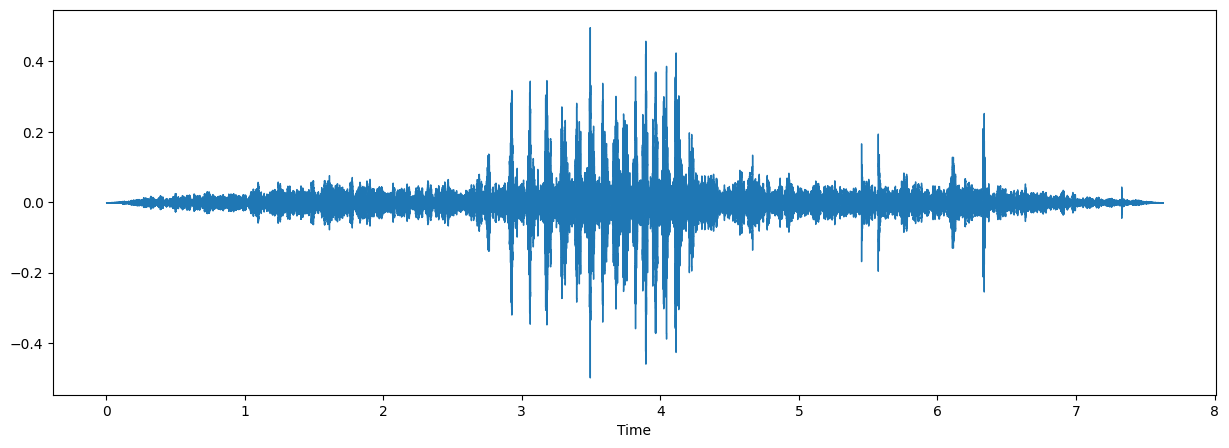

In [6]:
# Sample Audio Checking

# Set Plot Size
plt.figure(figsize=(15,5))

# Load Audio File to extract Audio Data and Sample Rate
audio_data, sample_rate = librosa.load(path='/content/drive/MyDrive/github-project/Bird sound classification using deep learning/Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan10.mp3')
librosa.display.waveshow(y=audio_data, sr=sample_rate)

# View and Hear Audio File
IPython.display.Audio(data='/content/drive/MyDrive/github-project/Bird sound classification using deep learning/Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan10.mp3')

In [7]:
# Audio will be automatically converted to Mono Channel [1-Dimentional Signal] Data
audio_data

array([-1.8189894e-11,  0.0000000e+00, -2.5465852e-11, ...,
        4.5474735e-13, -4.5474735e-13,  0.0000000e+00], dtype=float32)

In [8]:
# Audio will be automatically resampled to the rate of 22050Hz (default sr=22050)
sample_rate

22050

In [ ]:
#**Mel-Frequency Cepstral Coefficients (MFCC)**

#*MFCC help to extract the features from audio based on frequency and time charecteristics. This features will help in classification.*

#- It summarize the frequency distribution across window size.

#- So it analyse `frequency & time charecteristics` of the sound.

#- This audio representations help to identify the features for classification.


In [9]:
# Sample Audio Checking
mfccs_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)

In [10]:
# Sample Audio Checking
mfccs_features, mfccs_features.shape

(array([[-6.3337915e+02, -6.2952411e+02, -6.2050525e+02, ...,
         -6.1303510e+02, -6.2891858e+02, -6.3215344e+02],
        [ 0.0000000e+00,  5.4476233e+00,  1.7074574e+01, ...,
          2.0682634e+01,  5.6960430e+00,  1.7329885e+00],
        [ 0.0000000e+00,  5.4350033e+00,  1.4252247e+01, ...,
          1.4428495e+01,  5.2269416e+00,  1.7316210e+00],
        ...,
        [ 0.0000000e+00,  1.5935354e+00,  2.0140707e-01, ...,
         -1.5090740e+00,  2.0155950e+00,  1.1844728e+00],
        [ 0.0000000e+00,  1.4683881e+00,  5.9865737e-01, ...,
          4.5451343e-01,  2.3284578e+00,  1.1584530e+00],
        [ 0.0000000e+00,  1.3468971e+00,  4.8513275e-01, ...,
          4.6752942e-01,  2.5658598e+00,  1.1321471e+00]], dtype=float32),
 (40, 329))

which contains Mel-Frequency Cepstral Coefficients (MFCCs) computed from audio data.
The shape `(40, 673)` indicates that
- 40 rows (representing the 40 MFCC features)
- 673 columns (representing different frames or segments of the audio signal).

In [11]:
# Sample Audio Checking
np.mean(mfccs_features, axis=1)     # axis=1 means row wise mean calculation - shape=(40,0)  &  axis=0 means column wise mean caculation - shape=(673,)

array([-302.73083   ,   70.47813   ,   13.989463  ,   28.275862  ,
          9.768283  ,    7.4185357 ,    3.663607  ,   12.622561  ,
          0.9152409 ,    3.15177   ,    4.5321455 ,    6.7180853 ,
         -2.076896  ,    5.5894322 ,    3.0978475 ,    1.8796209 ,
         -0.49635005,    6.4944406 ,    2.0897276 ,    4.146482  ,
          2.351528  ,    7.5341434 ,    0.63787776,    5.8428    ,
          4.5193014 ,    5.587803  ,    1.6145756 ,    6.687456  ,
          2.1035836 ,    4.2177606 ,    2.5508912 ,    4.631444  ,
          0.40562922,    4.092282  ,    1.5406473 ,    3.7211802 ,
          0.5173263 ,    3.6272905 ,    0.56133217,    3.1007855 ],
      dtype=float32)

In [12]:
np.mean(mfccs_features, axis=1).shape

(40,)

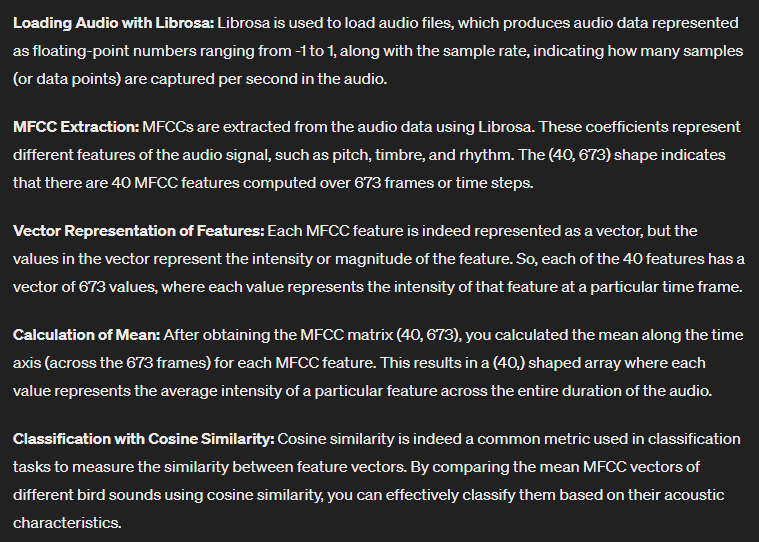

In [13]:
#data preprocessing
# Convert the mp3 Audio into Tensors

def audio_to_tensors(audio_file):
    # Extract the Signal and Sample_Rate from Audio
    audio, sample_rate =librosa.load(audio_file)

    # Extract the MFCC Features and Aggrigate
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_features = np.mean(mfccs_features, axis=1)

    # Convert into Tensors
    mfccs_tensors = tf.convert_to_tensor(mfccs_features, dtype=tf.float32)

    return mfccs_tensors

In [14]:
# Sample Audio
audio_sample = '/content/drive/MyDrive/github-project/Bird sound classification using deep learning/Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan10.mp3'
audio_to_tensors(audio_sample)

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([-302.73083   ,   70.47813   ,   13.989463  ,   28.275862  ,
          9.768283  ,    7.4185357 ,    3.663607  ,   12.622561  ,
          0.9152409 ,    3.15177   ,    4.5321455 ,    6.7180853 ,
         -2.076896  ,    5.5894322 ,    3.0978475 ,    1.8796209 ,
         -0.49635005,    6.4944406 ,    2.0897276 ,    4.146482  ,
          2.351528  ,    7.5341434 ,    0.63787776,    5.8428    ,
          4.5193014 ,    5.587803  ,    1.6145756 ,    6.687456  ,
          2.1035836 ,    4.2177606 ,    2.5508912 ,    4.631444  ,
          0.40562922,    4.092282  ,    1.5406473 ,    3.7211802 ,
          0.5173263 ,    3.6272905 ,    0.56133217,    3.1007855 ],
      dtype=float32)>

In [15]:
# Extract the Features from Audio Files

# Audio Directory Path
directory = '/content/drive/MyDrive/github-project/Bird sound classification using deep learning/Voice of Birds/Voice of Birds'

extracted_features = []

# Count the total number of files
total_files = sum(len(files) for _, _, files in os.walk(directory))

# Initialize tqdm with the total number of files
with tqdm(total=total_files, desc='Processing files') as pbar:

  for target_class in os.listdir(directory):                               # List of All Target Folder Names in Directory

      target_class_path = os.path.join(directory, target_class)            # Make a Target Folder Path in Directory

      for audio_file in os.listdir(target_class_path):                     # List of All Audio Files in Target Folder

          audio_path = os.path.join(directory, target_class, audio_file)   # Make a Audio File Path from Target Folder in Directory

          features = audio_to_tensors(audio_path)                          # Extract the Features from the Audio File

          extracted_features.append([features, target_class])              # Append the Features and Target_Class in List

          pbar.update(1)                                                   # Update the progress bar for each file processed


Processing files: 100%|██████████| 2073/2073 [26:11<00:00,  1.32it/s]


In [16]:
extracted_features[0]

[<tf.Tensor: shape=(40,), dtype=float32, numpy=
 array([-2.8851892e+02,  7.3875404e+01, -6.4231926e+01, -2.0869184e+01,
        -8.9157686e+00,  5.8880258e+00,  5.2031410e-01, -4.9954071e+00,
        -9.6936216e+00,  2.7154498e+00, -8.0318129e-01,  9.8982897e+00,
         3.9733231e-01, -2.8607423e+00, -3.3241615e+00,  1.4481831e-01,
        -1.9044600e+00,  4.6539874e+00, -2.6513877e+00,  2.8267155e+00,
         1.9811951e+00,  4.3973088e+00, -6.8206269e-01,  1.1220796e+00,
        -1.9912817e+00,  2.6660929e+00, -2.2962720e+00,  3.7462487e+00,
        -7.3349577e-01,  3.3749826e+00, -1.2299622e+00,  2.9641666e+00,
        -5.3353536e-01,  2.1463325e+00, -2.8148365e+00,  1.1160880e+00,
        -1.5299138e+00,  1.4791442e+00, -1.4696555e+00,  2.0787075e+00],
       dtype=float32)>,
 'Andean Guan_sound']

In [17]:
# Creating DataFrame from Extracted Features with Class Labels

features_df = pd.DataFrame(extracted_features, columns=['features', 'class'])
features_df

,features,class
0,"(tf.Tensor(-288.51892, shape=(), dtype=float32...",Andean Guan_sound
1,"(tf.Tensor(-204.62338, shape=(), dtype=float32...",Andean Guan_sound
2,"(tf.Tensor(-204.62338, shape=(), dtype=float32...",Andean Guan_sound
3,"(tf.Tensor(-302.73083, shape=(), dtype=float32...",Andean Guan_sound
4,"(tf.Tensor(-232.41954, shape=(), dtype=float32...",Andean Guan_sound
...,...,...
2068,"(tf.Tensor(-227.84633, shape=(), dtype=float32...",Yellow-legged Tinamou_sound
2069,"(tf.Tensor(-273.93497, shape=(), dtype=float32...",Yellow-legged Tinamou_sound
2070,"(tf.Tensor(-577.87445, shape=(), dtype=float32...",Yellow-legged Tinamou_sound
2071,"(tf.Tensor(-273.93497, shape=(), dtype=float32...",Yellow-legged Tinamou_sound


In [18]:
# Encoding Class Labels using LabelEncoder

target_encoding = LabelEncoder().fit_transform(features_df['class'])
target_encoding

array([  0,   0,   0, ..., 113, 113, 113])

In [19]:
# Adding Encoded Class Labels Column to DataFrame

features_df['target'] = target_encoding.tolist()
features_df

,features,class,target
0,"(tf.Tensor(-288.51892, shape=(), dtype=float32...",Andean Guan_sound,0
1,"(tf.Tensor(-204.62338, shape=(), dtype=float32...",Andean Guan_sound,0
2,"(tf.Tensor(-204.62338, shape=(), dtype=float32...",Andean Guan_sound,0
3,"(tf.Tensor(-302.73083, shape=(), dtype=float32...",Andean Guan_sound,0
4,"(tf.Tensor(-232.41954, shape=(), dtype=float32...",Andean Guan_sound,0
...,...,...,...
2068,"(tf.Tensor(-227.84633, shape=(), dtype=float32...",Yellow-legged Tinamou_sound,113
2069,"(tf.Tensor(-273.93497, shape=(), dtype=float32...",Yellow-legged Tinamou_sound,113
2070,"(tf.Tensor(-577.87445, shape=(), dtype=float32...",Yellow-legged Tinamou_sound,113
2071,"(tf.Tensor(-273.93497, shape=(), dtype=float32...",Yellow-legged Tinamou_sound,113


In [20]:
# Creating a Dictionary based on Class and Target columns for Future Prediction

prediction_dict = features_df.set_index('target')['class'].to_dict()
prediction_dict

{0: 'Andean Guan_sound',
 1: 'Andean Tinamou_sound',
 2: 'Australian Brushturkey_sound',
 3: 'Band-tailed Guan_sound',
 4: 'Barred Tinamou_sound',
 5: 'Bartletts Tinamou_sound',
 6: 'Baudo Guan_sound',
 7: 'Bearded Guan_sound',
 8: 'Berlepschs Tinamou_sound',
 9: 'Biak Scrubfowl_sound',
 10: 'Black Tinamou_sound',
 11: 'Black-billed Brushturkey_sound',
 12: 'Black-capped Tinamou_sound',
 13: 'Black-fronted Piping Guan_sound',
 14: 'Blue-throated Piping Guan_sound',
 15: 'Brazilian Tinamou_sound',
 16: 'Brown Tinamou_sound',
 17: 'Brushland Tinamou_sound',
 18: 'Buff-browed Chachalaca_sound',
 19: 'Cauca Guan_sound',
 20: 'Chaco Chachalaca_sound',
 21: 'Chestnut-bellied Guan_sound',
 22: 'Chestnut-headed Chachalaca_sound',
 23: 'Chestnut-winged Chachalaca_sound',
 24: 'Chilean Tinamou_sound',
 25: 'Choco Tinamou_sound',
 26: 'Cinereous Tinamou_sound',
 27: 'Collared Brushturkey_sound',
 28: 'Colombian Chachalaca_sound',
 29: 'Common Ostrich_sound',
 30: 'Crested Guan_sound',
 31: 'Curve

In [21]:
# Save to JSON File

with open(file='/content/prediction.json', mode='w') as f:
    json.dump(prediction_dict, f)

In [22]:
# Read the Prediction_Dictionary File

with open(file='/content/prediction.json', mode='r') as f:
    prediction_dict = json.load(f)
prediction_dict

{'0': 'Andean Guan_sound',
 '1': 'Andean Tinamou_sound',
 '2': 'Australian Brushturkey_sound',
 '3': 'Band-tailed Guan_sound',
 '4': 'Barred Tinamou_sound',
 '5': 'Bartletts Tinamou_sound',
 '6': 'Baudo Guan_sound',
 '7': 'Bearded Guan_sound',
 '8': 'Berlepschs Tinamou_sound',
 '9': 'Biak Scrubfowl_sound',
 '10': 'Black Tinamou_sound',
 '11': 'Black-billed Brushturkey_sound',
 '12': 'Black-capped Tinamou_sound',
 '13': 'Black-fronted Piping Guan_sound',
 '14': 'Blue-throated Piping Guan_sound',
 '15': 'Brazilian Tinamou_sound',
 '16': 'Brown Tinamou_sound',
 '17': 'Brushland Tinamou_sound',
 '18': 'Buff-browed Chachalaca_sound',
 '19': 'Cauca Guan_sound',
 '20': 'Chaco Chachalaca_sound',
 '21': 'Chestnut-bellied Guan_sound',
 '22': 'Chestnut-headed Chachalaca_sound',
 '23': 'Chestnut-winged Chachalaca_sound',
 '24': 'Chilean Tinamou_sound',
 '25': 'Choco Tinamou_sound',
 '26': 'Cinereous Tinamou_sound',
 '27': 'Collared Brushturkey_sound',
 '28': 'Colombian Chachalaca_sound',
 '29': 'C

In [23]:
# Converting Features into List
features = features_df['features'].tolist()
features

[<tf.Tensor: shape=(40,), dtype=float32, numpy=
 array([-2.8851892e+02,  7.3875404e+01, -6.4231926e+01, -2.0869184e+01,
        -8.9157686e+00,  5.8880258e+00,  5.2031410e-01, -4.9954071e+00,
        -9.6936216e+00,  2.7154498e+00, -8.0318129e-01,  9.8982897e+00,
         3.9733231e-01, -2.8607423e+00, -3.3241615e+00,  1.4481831e-01,
        -1.9044600e+00,  4.6539874e+00, -2.6513877e+00,  2.8267155e+00,
         1.9811951e+00,  4.3973088e+00, -6.8206269e-01,  1.1220796e+00,
        -1.9912817e+00,  2.6660929e+00, -2.2962720e+00,  3.7462487e+00,
        -7.3349577e-01,  3.3749826e+00, -1.2299622e+00,  2.9641666e+00,
        -5.3353536e-01,  2.1463325e+00, -2.8148365e+00,  1.1160880e+00,
        -1.5299138e+00,  1.4791442e+00, -1.4696555e+00,  2.0787075e+00],
       dtype=float32)>,
 <tf.Tensor: shape=(40,), dtype=float32, numpy=
 array([-204.62338   ,   86.42296   ,  -38.221363  ,   -8.752258  ,
         -17.210012  ,   14.943152  ,    1.5267172 ,   -4.2155848 ,
         -18.098389  , 

In [24]:
# Converting Targets into Lists
target = features_df['target'].tolist()
print(target)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1

In [25]:
# Converting Features and Targets to TensorFlow Tensors
features_tensor = tf.convert_to_tensor(features)
target_tensor = tf.convert_to_tensor(target)

In [26]:
# Creating TensorFlow Dataset from Tensors
dataset = tf.data.Dataset.from_tensor_slices((features_tensor, target_tensor))
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(40,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [27]:
# Split the dataset into batches
batch_size = 32
dataset = dataset.batch(batch_size)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [28]:
len(dataset)

65

In [29]:
# Define a Function process to Split Dataset into Training(80%), Validation(10%) and Testing(10%) Sets

def train_validation_test_split(dataset, train_size=0.8, validation_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):

    dataset_batch_count = len(dataset)                                                  # Batch Images dataset Length is 68
    train_batch_count = int(dataset_batch_count * train_size)                           # int(68*0.8) ---> 54 Batches are Training
    validation_test_batch_count = int(dataset_batch_count * validation_size)            # int(68*0.1) ---> 6 Batches are validation & Remaining Testing

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_size)                             # Suffling the Dataset help to Model Understand the Data Well

    train_ds = dataset.take(train_batch_count)                                          # First 54 Batches are Training_Dataset
    validation_ds = dataset.skip(train_batch_count).take(validation_test_batch_count)   # Remaining 14 Batches ---> Next 6 Batch are Validation_Dataset
    test_ds = dataset.skip(train_batch_count).skip(validation_test_batch_count)         # Pending 8 Batches are Testing

    return train_ds, validation_ds, test_ds

In [30]:
# Apply the Function
train_ds, validation_ds, test_ds = train_validation_test_split(dataset)
len(train_ds), len(validation_ds), len(test_ds)

(52, 6, 7)

(40,)
[-2.9814310e+02  6.6449432e+01  8.3540592e+00  1.7084257e+01
 -9.0206614e+00  2.0348028e+01 -4.4641356e+00  1.0405348e+01
 -1.7501843e+00  5.5949569e+00 -6.5515666e+00  2.4656632e+00
 -3.9989662e+00 -1.0632497e+00 -1.8888053e+00  6.2076956e-01
 -1.8606321e+00 -6.3520517e+00 -2.6044092e+00 -3.2396505e+00
 -3.0768633e+00 -8.0022249e+00 -6.3101130e+00 -2.6664386e+00
 -4.0322843e+00 -4.5525594e+00 -5.0609260e+00  5.1283181e-01
 -3.3691258e+00  1.5117782e-01 -4.5486879e+00  1.0474837e+00
 -5.1138368e+00 -1.1867447e+00 -5.5429292e+00 -1.6637026e+00
 -6.6101885e+00 -2.2369576e+00 -4.8200517e+00 -1.5159450e+00]

(32,)
2



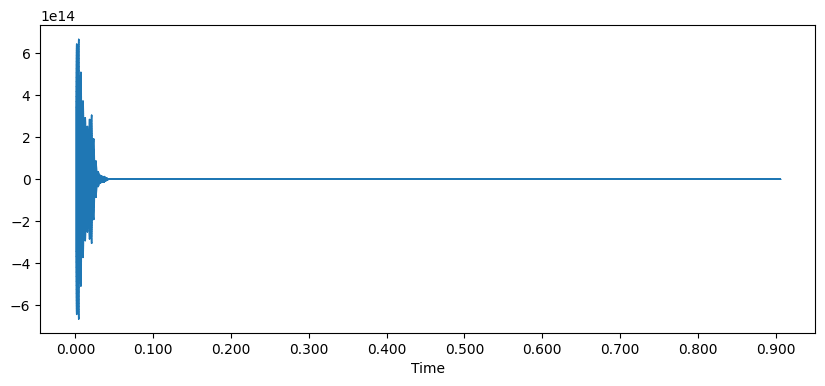

In [31]:
# Visualize the Image and Label Batches from TensorFlow Dataset

for audio_batch, label_batch in train_ds.take(1):
    print(audio_batch.numpy()[0].shape)
    print(audio_batch.numpy()[0])
    print()

    print(label_batch.numpy().shape)
    print(label_batch.numpy()[0])
    print()

    audio = librosa.feature.inverse.mfcc_to_audio(audio_batch.numpy())

    # Plot the reconstructed audio waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio)
    plt.show()

In [32]:
# Building an Optimized Data Pipeline for Enhanced Performance

# Training Dataset
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
validation_ds = validation_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Testing Dataset
test_ds = test_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

MODEL BUILDING AND TRAINING

In [33]:
# Define the Parameters of Input_shape, Channel and Target

mfcc_features = 40    # Extracted features from Audio
channel = 1           # Mono Channel
target = 114          # Output Classes

input_shape = (mfcc_features, channel)
input_shape

(40, 1)

In [34]:
# Build a CNN Model Architecture

model = keras.Sequential([

            # Input Layer
            keras.layers.Input(shape=input_shape),

            # 1st Conv Layer
            keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # 2nd Conv Layer
            keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # 3rd Conv Layer
            keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # Flatten and Convert into 1-Dimentional Vector
            keras.layers.Flatten(),

            # 1st Fully Connected Dense Layer
            keras.layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.L2(l2=1e-2)),
            keras.layers.Dropout(rate=0.3),

            # 2nd Fully Connected Dense Layer
            keras.layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.L2(l2=1e-2)),
            keras.layers.Dropout(rate=0.3),

            # Output Layer
            keras.layers.Dense(units=target, activation='softmax')
        ])

model

In [35]:
# Display the Model Summary

model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 128)           512       
                                                                 
 batch_normalization (Batch  (None, 38, 128)           512       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 19, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 256)           98560     
                                                                 
 batch_normalization_1 (Bat  (None, 17, 256)           1024      
 chNormalization)                                                
                                                        

In [36]:
# Compiling the Model with Optimizer, Loss, and Metrics

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model

In [37]:
# Model Training with Training_Dataset and Evaluated with Validation_Dataset

history = model.fit(train_ds,
                    batch_size=batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data = validation_ds)
history

Epoch 1/100
52/52 [==============================] - 11s 17ms/step - loss: 17.5348 - accuracy: 0.0091 - val_loss: 16.7672 - val_accuracy: 0.0000e+00
Epoch 2/100
52/52 [==============================] - 0s 8ms/step - loss: 17.2736 - accuracy: 0.0121 - val_loss: 16.6949 - val_accuracy: 0.0000e+00
Epoch 3/100
52/52 [==============================] - 0s 8ms/step - loss: 17.0412 - accuracy: 0.0193 - val_loss: 16.6364 - val_accuracy: 0.0000e+00
Epoch 4/100
52/52 [==============================] - 0s 8ms/step - loss: 16.8530 - accuracy: 0.0187 - val_loss: 16.5783 - val_accuracy: 0.0000e+00
Epoch 5/100
52/52 [==============================] - 0s 8ms/step - loss: 16.7386 - accuracy: 0.0241 - val_loss: 16.5065 - val_accuracy: 0.0104
Epoch 6/100
52/52 [==============================] - 0s 8ms/step - loss: 16.5833 - accuracy: 0.0260 - val_loss: 16.4537 - val_accuracy: 0.0156
Epoch 7/100
52/52 [==============================] - 0s 8ms/step - loss: 16.4387 - accuracy: 0.0398 - val_loss: 16.3939 - va

In [38]:
# Evaluating Model Performance on Test Dataset
model.evaluate(test_ds)

7/7 [==============================] - 0s 5ms/step - loss: 11.6283 - accuracy: 0.6116


[11.628289222717285, 0.6116071343421936]

In [39]:
# Accessing Training History Parameters
history.params

{'verbose': 1, 'epochs': 100, 'steps': 52}

In [40]:
# Accessing Keys of Training History
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
# Extracting Accuracy Metrics from Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extracting Loss Metrics from Training History
loss = history.history['loss']
val_loss = history.history['val_loss']

In [42]:
len(acc), len(val_acc), len(loss), len(val_loss)

(100, 100, 100, 100)

In [43]:
# Save the Model
model.save('/content/model.h5')

Text(0.5, 1.0, 'Training vs Validation Loss')

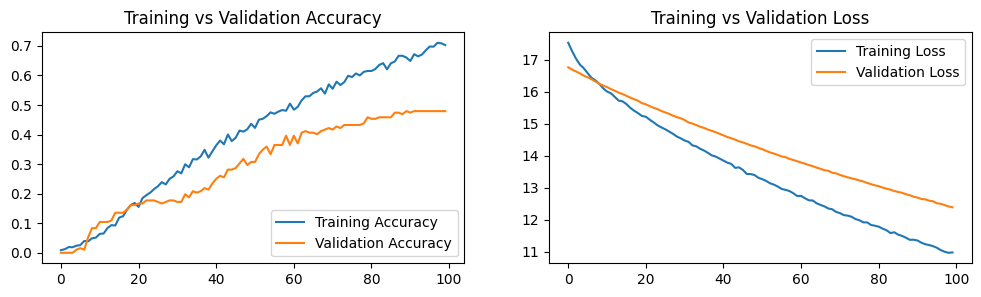

In [44]:
# Visualize the Acuuracy & Loss using Plots

plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

In [47]:
def prediction(audio_file):

    # Load the Prediction JSON File to Predict Target_Label
    with open('/content/prediction.json', mode='r') as f:
        prediction_dict = json.load(f)

    # Extract the Audio_Signal and Sample_Rate from Input Audio
    audio, sample_rate =librosa.load(audio_file)

    # Extract the MFCC Features and Aggrigate
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_features = np.mean(mfccs_features, axis=1)

    # Reshape MFCC features to match the expected input shape for Conv1D both batch & feature dimension
    mfccs_features = np.expand_dims(mfccs_features, axis=0)
    mfccs_features = np.expand_dims(mfccs_features, axis=2)

    # Convert into Tensors
    mfccs_tensors = tf.convert_to_tensor(mfccs_features, dtype=tf.float32)

    # Load the Model and Prediction
    model = tf.keras.models.load_model('/content/model.h5')
    prediction = model.predict(mfccs_tensors)

    # Find the Maximum Probability Value
    target_label = np.argmax(prediction)

    # Find the Target_Label Name using Prediction_dict
    predicted_class = prediction_dict[str(target_label)]
    confidence = round(np.max(prediction)*100, 2)

    print(f'Predicted Class : {predicted_class}')
    print(f'Confident : {confidence}%')

In [48]:
prediction('/content/drive/MyDrive/github-project/Bird sound classification using deep learning/Andean Guan3.mp3')

1/1 [==============================] - 0s 323ms/step
Predicted Class : Andean Guan_sound
Confident : 13.94%


In [49]:
prediction('/content/drive/MyDrive/github-project/Bird sound classification using deep learning/Cauca Guan7.mp3')

1/1 [==============================] - 0s 137ms/step
Predicted Class : Cauca Guan_sound
Confident : 12.92%
